In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
df = pd.read_csv("Output - Unificacion//Unificacion.csv")

## Datos con los que voy a trabajar

In [5]:
df.drop(columns =['Var_votos_ofi', 'Unnamed: 0', 'Circuito', 'barrio'], inplace = True)

In [6]:
df.columns

Index(['usd_m2', '$Obras', 'propietarios', 'educ_superior', 'nbi', 'Var_Com',
       'Var_delitos', 'Var_votos_bool'],
      dtype='object')

In [7]:
df['Var_votos_bool'].value_counts()

1    131
0     36
Name: Var_votos_bool, dtype: int64

## Train - Test

In [8]:
le = LabelEncoder()
y = le.fit_transform(df['Var_votos_bool'])
X = df.drop('Var_votos_bool', axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2, stratify=y)

## Funcion de evaluacion

In [10]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print (cm)
    print (cr)
    
    return a

all_models = {}

In [11]:
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5, 10, 20],
          'class_weight':[None, 'balanced']}

## Modelos y Feature importance 

### Random Forest

In [12]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
all_models['rf'] = {'model': rf,
                    'score': evaluate_model(rf)}

rf.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 7  2]
 [ 3 30]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.94      0.91      0.92        33

    accuracy                           0.88        42
   macro avg       0.82      0.84      0.83        42
weighted avg       0.89      0.88      0.88        42



RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [13]:
# Importancia de los features
importancias = rf.feature_importances_
print (all(importancias == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)))
# Calcule la desviación estándar de la importacia de los features haciendo un bucle sobre los árboles en el random forest
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importancias)[::-1]
nombres_features = X.columns

False


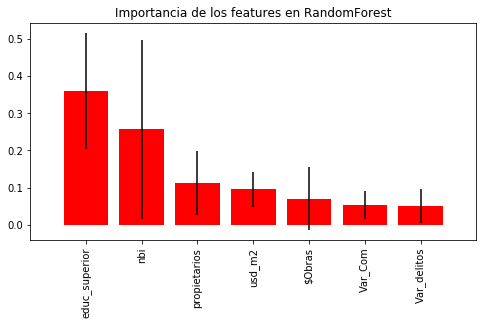

In [14]:
# Grafico la importancia de los features en el random forest
plt.figure(figsize=(8,4))
plt.title("Importancia de los features en RandomForest")
plt.bar(range(X.shape[1]), importancias[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), nombres_features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.rcParams.update({'font.size': 15})
plt.show()

In [15]:
# Gridsearch para random forest
gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gsrf.fit(X_train, y_train)
print (gsrf.best_params_)
print (gsrf.best_score_)

all_models['gsrf'] = {'model': gsrf.best_estimator_,
                      'score': evaluate_model(gsrf.best_estimator_)}

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
0.912
[[ 6  3]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.91      0.97      0.94        33

    accuracy                           0.90        42
   macro avg       0.89      0.82      0.85        42
weighted avg       0.90      0.90      0.90        42



### ExtraTrees

In [16]:
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)
all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}

et.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 6  3]
 [ 2 31]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.91      0.94      0.93        33

    accuracy                           0.88        42
   macro avg       0.83      0.80      0.82        42
weighted avg       0.88      0.88      0.88        42



ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [17]:
# Importancia de los features
importancias = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)
indices = np.argsort(importancias)[::-1]
nombres_features = X.columns

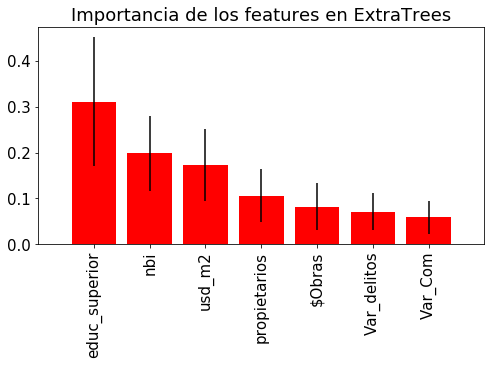

In [18]:
# Graficar la importancia de los features
plt.figure(figsize=(8,4))
plt.title("Importancia de los features en ExtraTrees")
plt.bar(range(X_train.shape[1]), importancias[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), nombres_features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.rcParams.update({'font.size': 15})
plt.show()

In [19]:
gset = GridSearchCV(ExtraTreesClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gset.fit(X_train, y_train)
print (gset.best_params_)
print (gset.best_score_)

all_models['gset'] = {'model': gset.best_estimator_,
                      'score': evaluate_model(gset.best_estimator_)}

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
0.904
[[ 5  4]
 [ 0 33]]
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.89      1.00      0.94        33

    accuracy                           0.90        42
   macro avg       0.95      0.78      0.83        42
weighted avg       0.92      0.90      0.89        42



## KNN

In [20]:
a = evaluate_model(KNeighborsClassifier())

[[ 2  7]
 [ 4 29]]
              precision    recall  f1-score   support

           0       0.33      0.22      0.27         9
           1       0.81      0.88      0.84        33

    accuracy                           0.74        42
   macro avg       0.57      0.55      0.55        42
weighted avg       0.70      0.74      0.72        42



In [21]:
# Grid search
params = {'n_neighbors': range(2,60)}
gsknn = GridSearchCV(KNeighborsClassifier(),params, n_jobs=-1,cv=KFold(n_splits=3, shuffle=True))

In [22]:
gsknn.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': range(2, 60)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
gsknn.best_params_

{'n_neighbors': 3}

In [24]:
gsknn.best_score_

0.8

In [25]:
evaluate_model(gsknn.best_estimator_)

[[ 2  7]
 [ 5 28]]
              precision    recall  f1-score   support

           0       0.29      0.22      0.25         9
           1       0.80      0.85      0.82        33

    accuracy                           0.71        42
   macro avg       0.54      0.54      0.54        42
weighted avg       0.69      0.71      0.70        42



0.7142857142857143

In [26]:
all_models['knn'] = {'model': gsknn.best_estimator_,
                     'score': gsknn.best_score_}

### Bagging + KNN

In [27]:
baggingknn = BaggingClassifier(KNeighborsClassifier())

In [28]:
evaluate_model(baggingknn)

[[ 2  7]
 [ 4 29]]
              precision    recall  f1-score   support

           0       0.33      0.22      0.27         9
           1       0.81      0.88      0.84        33

    accuracy                           0.74        42
   macro avg       0.57      0.55      0.55        42
weighted avg       0.70      0.74      0.72        42



0.7380952380952381

In [29]:
bagging_params = {'n_estimators': [50, 100],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.1, 1.0],
                  'bootstrap_features': [True, False]}


gsbaggingknn = GridSearchCV(baggingknn,
                            bagging_params, n_jobs=-1,
                            cv=KFold(n_splits=3, shuffle=True))

In [30]:
gsbaggingknn.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                                             leaf_size=30,
                                                                             metric='minkowski',
                                                                             metric_params=None,
                                                                             n_jobs=None,
                                                                             n_neighbors=5,
                                                                             p=2,
                                                                             weights='uniform'),
                                         bootstrap=True,
                                         bootstrap_features=False,
                     

In [31]:
gsbaggingknn.best_params_

{'bootstrap_features': True,
 'max_features': 1.0,
 'max_samples': 0.7,
 'n_estimators': 100}

In [32]:
all_models['gsbaggingknn'] = {'model': gsbaggingknn.best_estimator_,
                              'score': evaluate_model(gsbaggingknn.best_estimator_)}

[[ 0  9]
 [ 0 33]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.79      1.00      0.88        33

    accuracy                           0.79        42
   macro avg       0.39      0.50      0.44        42
weighted avg       0.62      0.79      0.69        42



C:\Users\martin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Comparación de modelos

,score
model,
gsrf,0.90
gset,0.90
rf,0.88
et,0.88
knn,0.80
gsbaggingknn,0.79


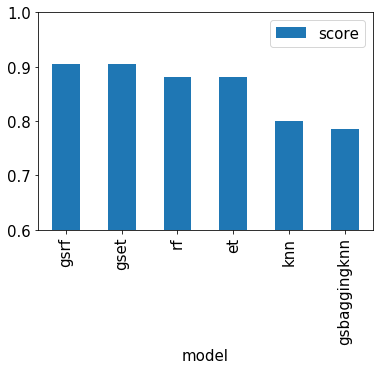

In [33]:
scores = pd.DataFrame([(k, v['score']) for k, v in all_models.items()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)

plt.rcParams.update({'font.size': 15})

scores.plot(kind='bar')
plt.ylim(0.6, 1)

scores

## Seleccion de modelo

In [44]:
def retest(model):
    scores = cross_val_score(model, X_train, y_train,
                             cv=StratifiedKFold(n_splits=3, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in all_models.items():
    cvres = retest(v['model'])
    print (k), 
    all_models[k]['cvres'] = cvres

rf
gsrf
et
gset
knn
gsbaggingknn


,score,error
model,,
gset,0.91,0.04
gsrf,0.90,0.03
rf,0.86,0.04
et,0.86,0.00
gsbaggingknn,0.82,0.01
knn,0.77,0.03


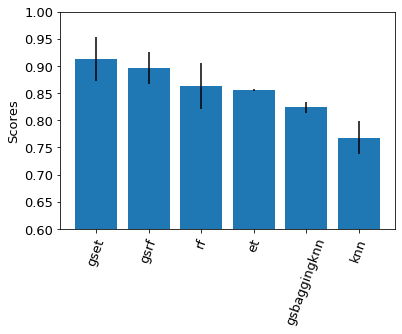

In [45]:
cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in all_models.items()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)


fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error,
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.ylim(0.6, 1)
plt.rcParams.update({'font.size': 13})

cvscores